# HW1 AA274A Problem 3, aka HW2 Problem 1

In this problem, you will write a trajectory optimization algorithm to generate a feasible trajectory subject to some constraints. 

Our setup includes the "ego" vehicle (meaning the agent we control), a static obstacle, and a goal position to be reached.

In this setup, we will not make the assumption of differential flatness and instead solve the problem with a nonlinear optimizer!


# Problem Setup
We will first consider the case in which we are trying to generate a trajectory for a Turtlebot that must avoid an object. 

The agent has an initial position, a goal position, and a big obstacle in the center of the initial path. 

Our agent therefore must generate a trajectory that is dynamically feasible, does not collide with the obstacle, and reaches the final goal pose.

## Required packages 
```bash
uv venv --python 3.12
source .venv/bin/activate
uv pip install numpy
uv pip install matplotlib
uv pip install scipy
uv pip install ipykernel
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
import typing as T

# Visualizing the Scene

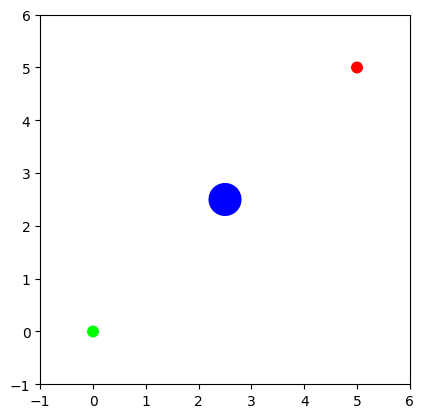

In [2]:
# Initial conditions and parameters
EGO_START_POS, EGO_FINAL_GOAL_POS = (0.0,0.0), (5.0,5.0)
EGO_RADIUS, OBS_RADIUS = 0.1, 0.3
OBSTACLE_POS = (2.5, 2.5)

def render_scene(traj=None, print_alpha=None):
  _, ax = plt.subplots()
  ego_circle_start = plt.Circle(EGO_START_POS, radius=EGO_RADIUS, color='lime')
  ego_circle_end   = plt.Circle(EGO_FINAL_GOAL_POS, radius=EGO_RADIUS, color='red')
  obs_circle       = plt.Circle(OBSTACLE_POS, radius=OBS_RADIUS, color='blue')
  ax.add_patch(obs_circle)
  if traj is not None:
    for i in range(traj.shape[0]):
      x,y,theta = traj[i]
      ego_circle_current = plt.Circle((x, y), radius=EGO_RADIUS, color='cyan')
      ax.add_patch(ego_circle_current)
      ego_arrow_current = plt.arrow(x, y, dx=np.cos(theta)/2, dy=np.sin(theta)/2, head_width=0.1)
      ax.add_patch(ego_arrow_current)
  ax.add_patch(ego_circle_start)
  ax.add_patch(ego_circle_end)
  ax.set_xlim((-1.0, 6.0))
  ax.set_ylim((-1.0, 6.0))
  ax.set_aspect('equal')
  if print_alpha is not None:
    plt.title("Alpha: {:.2f}".format(print_alpha))
  return plt

# VIZUALIZE THE INITIAL SCENE
# RED circle is the obstacle
# GREEN is ego start position
# BLUE is obstacle position
plt = render_scene()
plt.show()

## Code Setup

Here we will define some essential values for our problem (such as the initial state, final state, etc.). We have also provided two helper functions that may be useful for you!

**TODO:** Fill in code for the initial and final state of the ego agent below. Some hints are provided in the code comments

In [3]:
############################## Code starts here ##############################
# TODO: Define the initial and final state as numpy arrays for the ego agent here
# HINTS: Our state is a 3 dimensional vector [x, y, heading].
s_0 = np.array([EGO_START_POS[0], EGO_START_POS[1], np.pi/2])  # Initial state.
s_f = np.array([EGO_FINAL_GOAL_POS[0], EGO_FINAL_GOAL_POS[1], np.pi/2])  # Final state.
############################## Code ends here ##############################

N = 50  # Number of time discretization nodes (0, 1, ... N).
s_dim = 3  # State dimension; 3 for (x, y, th).
u_dim = 2  # Control dimension; 2 for (V, om).
v_max = 0.5  # Maximum linear velocity.
om_max = 1.0  # Maximum angular velocity.

def pack_decision_variables(t_f: float, s: np.ndarray, u: np.ndarray) -> np.ndarray:
    """Packs decision variables (final time, states, controls) into a 1D vector.

    Args:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).

    Returns:
        An array `z` of shape (1 + (N + 1) * s_dim + N * u_dim,).
    """
    return np.concatenate([[t_f], s.ravel(), u.ravel()])

def unpack_decision_variables(z: np.ndarray) -> T.Tuple[float, np.ndarray, np.ndarray]:
    """Unpacks a 1D vector into decision variables (final time, states, controls).

    Args:
        z: An array of shape (1 + (N + 1) * s_dim + N * u_dim,).

    Returns:
        t_f: Final time, a scalar.e objective is to drive from
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    """
    t_f = float(z[0])
    s = z[1:1 + (N + 1) * s_dim].reshape(N + 1, s_dim)
    u = z[-N * u_dim:].reshape(N, u_dim)
    return t_f, s, u

## Trajectory Optimization

Next, we will define a function to set up and solve the trajectory optimization problem. Consider the following questions:



1.   What is the cost for a given trajectory?
2.   What are the **constraints** that the trajectory must obey? Constraints here are *equality* constraints.

We will use scipy.optimize.minimize to solve this nonlinear optimization problem. You can find some documentation for this function [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)



In [10]:
def optimize_trajectory(alpha: float = 1.0, verbose: bool = False):
    """Computes the optimal trajectory as a function of `alpha`.

    Args:
        alpha in the HW writeup.

    Returns:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    """

    def cost(z):
        ############################## Code starts here ##############################
        # TODO: Define a cost function here
        # HINT: you may find `unpack_decision_variables` useful. z is the packed 1D representation of t, s and u
        # Return the value of the cost.
        t_f, _, u = unpack_decision_variables(z)
        dt = t_f / N
        
        # tcost = sum( ( alpha + np.sum(u**2, axis=1) ) * dt)
        tcost = sum( [ (alpha + v**2 + omega**2) * dt for v, omega in u ]  )
        return tcost
        ############################## Code ends here ##############################

    # Initialize the trajectory with a straight line
    z_guess = pack_decision_variables(
        20, s_0 + np.linspace(0, 1, N + 1)[:, np.newaxis] * (s_f - s_0),
        np.ones(N * u_dim))

    # Minimum and Maximum bounds on states and controls
    # This is because we would want to include safety limits
    # for omega (steering) and velocity (speed limit)
    bounds = Bounds(
        pack_decision_variables(
            0., -np.inf * np.ones((N + 1, s_dim)),
            np.array([0.01, -om_max]) * np.ones((N, u_dim))), # type: ignore
        pack_decision_variables(
            np.inf, np.inf * np.ones((N + 1, s_dim)),
            np.array([v_max, om_max]) * np.ones((N, u_dim))) # type: ignore
    )

    # Define the equality constraints
    def eq_constraints(z):
        t_f, s, u = unpack_decision_variables(z)
        dt = t_f / N
        constraint_list = []
        for i in range(N):
            V, om = u[i]
            x, y, th = s[i]
            ############################## Code starts here ##############################
            # TODO: Append to `constraint_list` with dynanics constraints
            x_next = x + V * np.cos(th) * dt
            y_next = y + V * np.sin(th) * dt
            th_next = th + om * dt
            s_next = np.array([x_next, y_next, th_next])
            constraint_list.append(s[i + 1] - s_next)
            ############################## Code ends here ##############################
            
        ############################## Code starts here ##############################
        # TODO: Append to `constraint_list` with initial and final state constraints
        constraint_list.append(s[0] - s_0)
        constraint_list.append(s[-1] - s_f)
        ############################## Code ends here ##############################
        return np.concatenate(constraint_list)

    # Define the inequality constraints
    def ineq_constraints(z):
        _, s, _ = unpack_decision_variables(z)
        constraint_list = []
        ############################## Code starts here ##############################
        obs_x, obs_y = OBSTACLE_POS
        for i in range(N):
            x, y, _ = s[i]
            dist = np.linalg.norm(np.array([x, y]) - np.array([obs_x, obs_y]))            
            constraint_list.append( dist - (EGO_RADIUS + OBS_RADIUS) )                    
        return constraint_list
        ############################## Code ends here ################################

    # TODO minimize cost(z) by changing z  and ensure constraints are satisfied 
    result = minimize(cost, 
                      z_guess, 
                      bounds=bounds, 
                      constraints = [ {'type' : 'eq',   'fun' : eq_constraints},
                                      {'type' : 'ineq', 'fun' : ineq_constraints} ] 
                      )
    if verbose:
        print(result)

    return unpack_decision_variables(result.x)

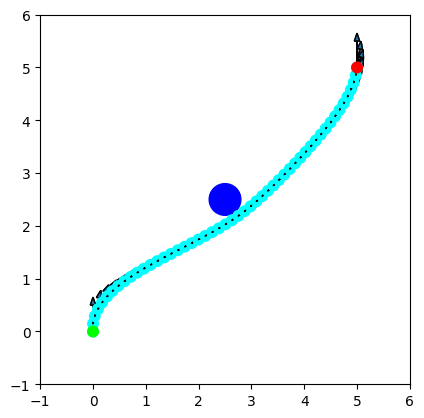

In [11]:
# Call the trajectory optimizer
t, s, u = optimize_trajectory()
# Plot optimized trajectory
plt = render_scene(s)
plt.show()


## Varying alpha

Let us now experiment with different values of alpha to see how the output changes. We have included three examples below, but feel free to experiment with other values as well!

Let's write a small wrapper function which gives us a plot of the trajectory for a given value of alpha

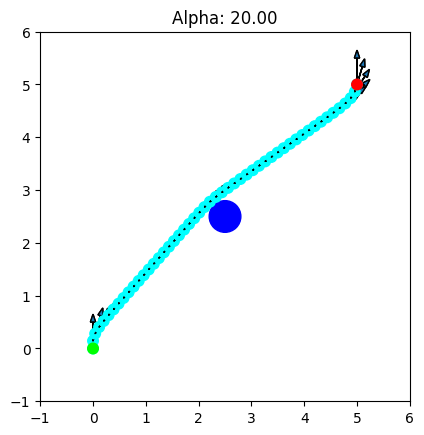

In [12]:
def show_traj_plan(alpha=1.0):
  t, s, u = optimize_trajectory(alpha)
  plt = render_scene(s, print_alpha=alpha)
  plt.show()

show_traj_plan(alpha=20.0)

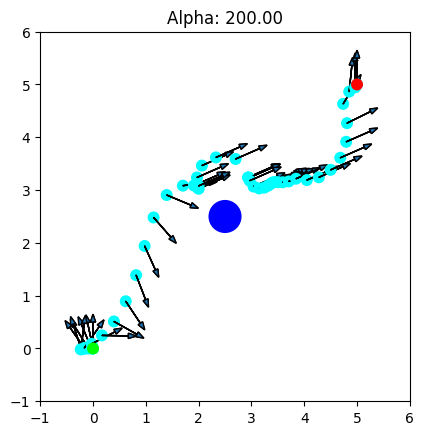

In [13]:
show_traj_plan(alpha=200.0)